In [1]:
import os
import cv2
import numpy as np
import shutil

# Define folder paths (update as per your dataset)
folder_paths = [
    "/kaggle/input/fake-images/images",  # Contains subfolder
    "/kaggle/input/fake-images/images3",
    "/kaggle/input/fake-images/images4"
]
output_dir = "/kaggle/working/combined_images"

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Move all images from given folders to output directory
image_extensions = ('.png', '.jpg', '.jpeg')
total_images_before = 0

for folder in folder_paths:
    for root, _, files in os.walk(folder):
        for file in files:
            if file.lower().endswith(image_extensions):
                src_path = os.path.join(root, file)
                dst_path = os.path.join(output_dir, file)
                shutil.copy2(src_path, dst_path)  # Copy instead of move
                total_images_before += 1

# Function to check if an image is completely black
def is_black_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read in grayscale
    return np.all(img == 0)  # True if all pixels are black

# Remove black images and count them
black_images_removed = 0

for img_name in os.listdir(output_dir):
    img_path = os.path.join(output_dir, img_name)
    if os.path.isfile(img_path) and is_black_image(img_path):
        os.remove(img_path)  # Delete black image
        black_images_removed += 1
        print(f"Removed black image: {img_name}")

# Count remaining images after cleaning
total_images_after = total_images_before - black_images_removed

# Print results
print("\n===== Dataset Preprocessing Summary =====")
print(f"Total images before preprocessing: {total_images_before}")
print(f"Black images removed: {black_images_removed}")
print(f"Total images after preprocessing: {total_images_after}")


Removed black image: fake_5415.jpg
Removed black image: fake_2995.jpg
Removed black image: fake_1355.jpg
Removed black image: fake_4987.jpg
Removed black image: fake_3780.jpg
Removed black image: fake_3480.jpg
Removed black image: fake_3559.jpg
Removed black image: fake_2119.jpg
Removed black image: fake_1138.jpg
Removed black image: fake_4892.jpg
Removed black image: fake_4477.jpg
Removed black image: fake_559.jpg
Removed black image: fake_2325.jpg
Removed black image: fake_1209.jpg
Removed black image: fake_801.jpg
Removed black image: fake_4904.jpg
Removed black image: fake_3317.jpg
Removed black image: fake_1823.jpg
Removed black image: fake_5085.jpg
Removed black image: fake_4327.jpg
Removed black image: fake_1224.jpg
Removed black image: fake_3246.jpg
Removed black image: fake_5011.jpg
Removed black image: fake_2017.jpg
Removed black image: fake_3827.jpg
Removed black image: fake_3868.jpg
Removed black image: fake_2851.jpg
Removed black image: fake_172.jpg
Removed black image: fa

Running on CPU/GPU
Found 10202 files belonging to 2 classes.
Using 8162 files for training.
Found 10202 files belonging to 2 classes.
Using 2040 files for validation.
Epoch 1/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 102s 297ms/step - accuracy: 0.5778 - loss: 3.1281 - val_accuracy: 0.6593 - val_loss: 2.6593 - learning_rate: 1.0000e-04
Epoch 2/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 52s 202ms/step - accuracy: 0.6250 - loss: 2.6978 - val_accuracy: 0.7064 - val_loss: 2.2985 - learning_rate: 1.0000e-04
Epoch 3/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 52s 204ms/step - accuracy: 0.6314 - loss: 2.4357 - val_accuracy: 0.7211 - val_loss: 2.0917 - learning_rate: 1.0000e-04
Epoch 4/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 52s 202ms/step - accuracy: 0.6451 - loss: 2.1976 - val_accuracy: 0.7020 - val_loss: 1.9546 - learning_rate: 1.0000e-04
Epoch 5/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 52s 203ms/step - accuracy: 0.6428 - loss: 2.0427 - val_accuracy: 0.7196 - val_loss: 1.7812 - learning_rate: 1.0000e-04
Epoch 6/20
256/256 ━━━━━━━━━━━━━━━━━━

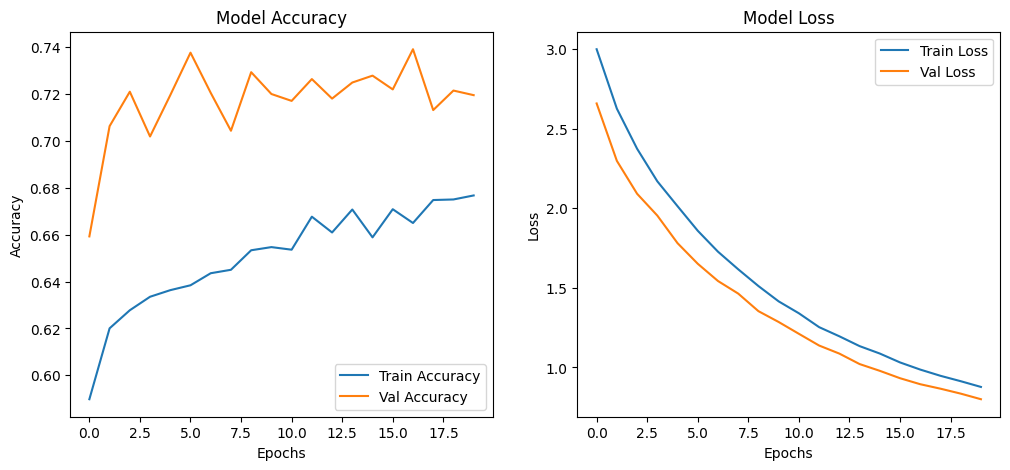

64/64 ━━━━━━━━━━━━━━━━━━━━ 21s 190ms/step
              precision    recall  f1-score   support

         0.0       0.46      0.50      0.48       998
         1.0       0.47      0.43      0.45      1042

    accuracy                           0.46      2040
   macro avg       0.47      0.47      0.46      2040
weighted avg       0.47      0.46      0.46      2040



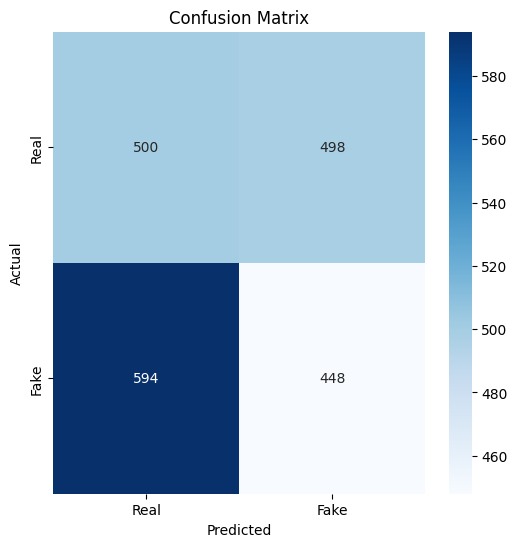

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os
from glob import glob
import shutil

def initialize_tpu():
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.TPUStrategy(tpu)
        print("Running on TPU")
    except ValueError:
        strategy = tf.distribute.get_strategy()
        print("Running on CPU/GPU")
    return strategy

strategy = initialize_tpu()

# Dataset directories
fake_dir = "/kaggle/working/combined_images"
real_dir = "/kaggle/input/flickrfaceshq-dataset-nvidia-resized-256px/resized"

temp_dataset_dir = "/kaggle/working/temp_dataset"
os.makedirs(temp_dataset_dir, exist_ok=True)

# Creating subdirectories
real_subset_dir = os.path.join(temp_dataset_dir, "real")
fake_subset_dir = os.path.join(temp_dataset_dir, "fake")
os.makedirs(real_subset_dir, exist_ok=True)
os.makedirs(fake_subset_dir, exist_ok=True)

# Select 5100 real images
real_images = glob(os.path.join(real_dir, "*.jpg"))[:5100]
fake_images = glob(os.path.join(fake_dir, "*.jpg"))

# Copy images to temporary dataset directory
for img in real_images:
    shutil.copy(img, real_subset_dir)
for img in fake_images:
    shutil.copy(img, fake_subset_dir)

# Image size & batch size
IMG_SIZE = (160, 160)
BATCH_SIZE = 32

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
])

# Load data using tf.data pipeline
def load_data():
    train_data = image_dataset_from_directory(
        temp_dataset_dir,
        label_mode="binary",
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        validation_split=0.2,
        subset="training",
        seed=42
    ).map(lambda x, y: (data_augmentation(x, training=True), y))
    
    val_data = image_dataset_from_directory(
        temp_dataset_dir,
        label_mode="binary",
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        validation_split=0.2,
        subset="validation",
        seed=42
    )
    return train_data, val_data

train_data, val_data = load_data()

# Define Model
def build_model():
    with strategy.scope():
        base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(160, 160, 3))
        base_model.trainable = False
        
        x = GlobalAveragePooling2D()(base_model.output)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
        x = Dropout(0.4)(x)
        output = Dense(1, activation='sigmoid')(x)
        
        model = Model(inputs=base_model.input, outputs=output)
        model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_model()

# Train model
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

history = model.fit(train_data, validation_data=val_data, epochs=20, callbacks=callbacks)

# Plot Training History
def plot_history(history):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

plot_history(history)

# Evaluate Model
val_preds = model.predict(val_data)
val_labels = np.concatenate([y for x, y in val_data], axis=0)
val_preds = (val_preds > 0.5).astype(int)

print(classification_report(val_labels, val_preds))

# Confusion Matrix
cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Running on CPU/GPU
Found 10202 files belonging to 2 classes.
Using 8162 files for training.
Found 10202 files belonging to 2 classes.
Using 2040 files for validation.
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 249s 840ms/step - accuracy: 0.7702 - loss: 4.7341 - val_accuracy: 0.9809 - val_loss: 3.6139 - learning_rate: 1.0000e-04
Epoch 2/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 186s 724ms/step - accuracy: 0.9330 - loss: 3.4917 - val_accuracy: 0.9838 - val_loss: 2.8212 - learning_rate: 1.0000e-04
Epoch 3/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 185s 724ms/step - accuracy: 0.9469 - loss: 2.7440 - val_accuracy: 0.9789 - val_loss: 2.2535 - learning_rate: 1.0000e-04
Epoch 4/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 186s 725ms/step - accuracy: 0.9595 - loss: 2.1831 - val_accuracy: 0.9819 - val_loss: 1.8011 - learning_rate: 1.0000e-04
Epoch 5/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 185s 723ms/step - accuracy: 0.9563 - loss: 1.7650 - val_accuracy: 0.9789 - val_loss: 1.4511 - learning

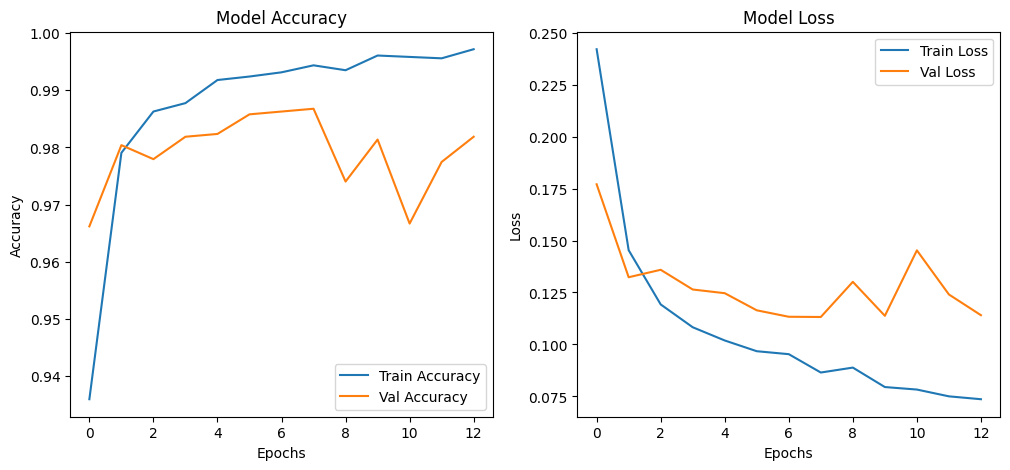

64/64 ━━━━━━━━━━━━━━━━━━━━ 19s 191ms/step
              precision    recall  f1-score   support

         0.0       0.48      0.50      0.49       998
         1.0       0.50      0.49      0.50      1042

    accuracy                           0.49      2040
   macro avg       0.49      0.49      0.49      2040
weighted avg       0.49      0.49      0.49      2040



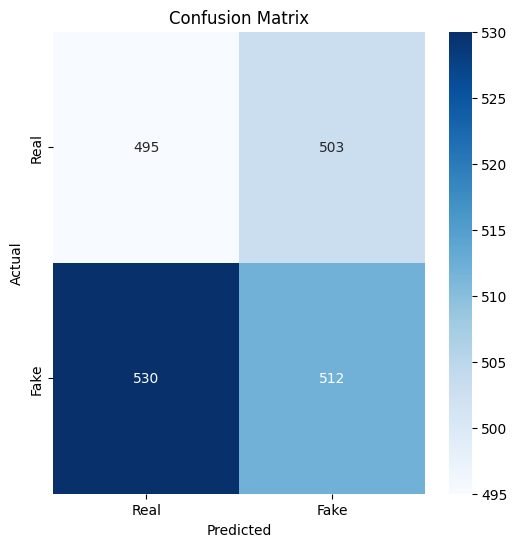

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os
from glob import glob
import shutil

def initialize_tpu():
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.TPUStrategy(tpu)
        print("Running on TPU")
    except ValueError:
        strategy = tf.distribute.get_strategy()
        print("Running on CPU/GPU")
    return strategy

strategy = initialize_tpu()

# Dataset directories
fake_dir = "/kaggle/working/combined_images"  # Fake images
real_dir = "/kaggle/input/flickrfaceshq-dataset-nvidia-resized-256px/resized"  # Real images

temp_dataset_dir = "/kaggle/working/temp_dataset"
os.makedirs(temp_dataset_dir, exist_ok=True)

# Creating subdirectories
real_subset_dir = os.path.join(temp_dataset_dir, "real")
fake_subset_dir = os.path.join(temp_dataset_dir, "fake")
os.makedirs(real_subset_dir, exist_ok=True)
os.makedirs(fake_subset_dir, exist_ok=True)

# Select 5100 real images
real_images = glob(os.path.join(real_dir, "*.jpg"))[:5100]  # Corrected to JPG
fake_images = glob(os.path.join(fake_dir, "*.jpg"))  # Corrected to JPG

# Copy images to temporary dataset directory
for img in real_images:
    shutil.copy(img, real_subset_dir)
for img in fake_images:
    shutil.copy(img, fake_subset_dir)

# Image size & batch size
IMG_SIZE = (300, 300)
BATCH_SIZE = 32

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
])

# Load data using tf.data pipeline
def load_data():
    train_data = image_dataset_from_directory(
        temp_dataset_dir,
        label_mode="binary",
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        validation_split=0.2,
        subset="training",
        seed=42
    ).map(lambda x, y: (data_augmentation(x, training=True), y))  # Apply augmentation
    
    val_data = image_dataset_from_directory(
        temp_dataset_dir,
        label_mode="binary",
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        validation_split=0.2,
        subset="validation",
        seed=42
    )
    return train_data, val_data

train_data, val_data = load_data()

# Define Model (EfficientNetB3)
def build_model():
    with strategy.scope():  # Enable TPU support
        base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(300, 300, 3))
        base_model.trainable = False  # Freeze base model initially
        
        x = GlobalAveragePooling2D()(base_model.output)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
        x = Dropout(0.4)(x)
        output = Dense(1, activation='sigmoid')(x)  # Fixed output layer initialization
        
        model = Model(inputs=base_model.input, outputs=output)
        model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model, base_model  # Return both model and base_model

model, base_model = build_model()

# Train model
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

history = model.fit(train_data, validation_data=val_data, epochs=20, callbacks=callbacks)

# Fine-tune the model
base_model.trainable = True  # Now base_model is accessible
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])
history_fine = model.fit(train_data, validation_data=val_data, epochs=20, callbacks=callbacks)

# Plot Training History
def plot_history(history):
    plt.figure(figsize=(12, 5))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

plot_history(history_fine)

# Evaluate Model
val_preds = model.predict(val_data)
val_labels = np.concatenate([y for x, y in val_data], axis=0)
val_preds = (val_preds > 0.5).astype(int)

print(classification_report(val_labels, val_preds))

# Confusion Matrix
cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Running on CPU/GPU
Found 10202 files belonging to 2 classes.
Using 8162 files for training.
Found 10202 files belonging to 2 classes.
Using 2040 files for validation.
111650432/111650432 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 64s 192ms/step - accuracy: 0.8085 - loss: 4.0703 - val_accuracy: 0.9877 - val_loss: 3.1006 - learning_rate: 1.0000e-04
Epoch 2/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 39s 151ms/step - accuracy: 0.9704 - loss: 2.8951 - val_accuracy: 0.9956 - val_loss: 2.2756 - learning_rate: 1.0000e-04
Epoch 3/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 39s 151ms/step - accuracy: 0.9784 - loss: 2.1568 - val_accuracy: 0.9980 - val_loss: 1.6875 - learning_rate: 1.0000e-04
Epoch 4/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 39s 151ms/step - accuracy: 0.9854 - loss: 1.6012 - val_accuracy: 0.9980 - val_loss: 1.2520 - learning_rate: 1.0000e-04
Epoch 5/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 39s 151ms/step - accuracy: 0.9897 - loss: 1.1863 - val_accuracy: 0.9980 - val_loss: 0.9216 - learning_ra

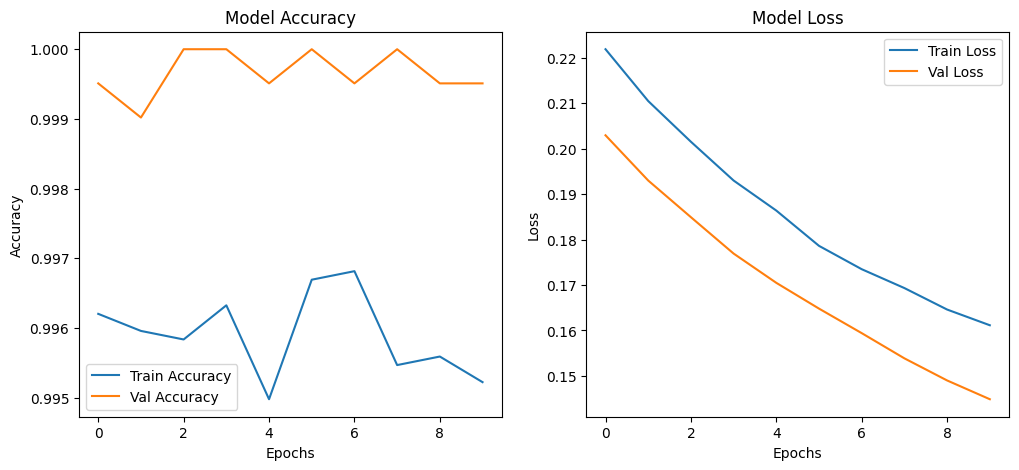

64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 160ms/step
              precision    recall  f1-score   support

         0.0       0.46      0.46      0.46       998
         1.0       0.48      0.48      0.48      1042

    accuracy                           0.47      2040
   macro avg       0.47      0.47      0.47      2040
weighted avg       0.47      0.47      0.47      2040



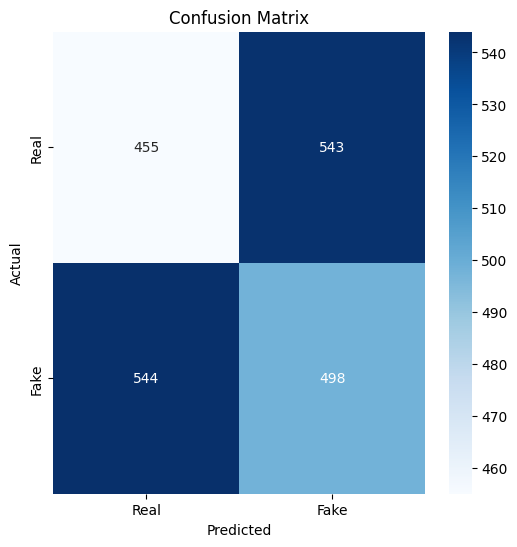

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import ConvNeXtTiny
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os
from glob import glob
import shutil

def initialize_tpu():
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.TPUStrategy(tpu)
        print("Running on TPU")
    except ValueError:
        strategy = tf.distribute.get_strategy()
        print("Running on CPU/GPU")
    return strategy

strategy = initialize_tpu()

# Dataset directories
fake_dir = "/kaggle/working/combined_images"
real_dir = "/kaggle/input/flickrfaceshq-dataset-nvidia-resized-256px/resized"

temp_dataset_dir = "/kaggle/working/temp_dataset"
os.makedirs(temp_dataset_dir, exist_ok=True)

# Creating subdirectories
real_subset_dir = os.path.join(temp_dataset_dir, "real")
fake_subset_dir = os.path.join(temp_dataset_dir, "fake")
os.makedirs(real_subset_dir, exist_ok=True)
os.makedirs(fake_subset_dir, exist_ok=True)

# Select 5100 real images
real_images = glob(os.path.join(real_dir, "*.jpg"))[:5100]
fake_images = glob(os.path.join(fake_dir, "*.jpg"))

# Copy images to temporary dataset directory
for img in real_images:
    shutil.copy(img, real_subset_dir)
for img in fake_images:
    shutil.copy(img, fake_subset_dir)

# Image size & batch size
IMG_SIZE = (300, 300)
BATCH_SIZE = 32

# Load data using tf.data pipeline
def load_data():
    train_data = image_dataset_from_directory(
        temp_dataset_dir,
        label_mode="binary",
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        validation_split=0.2,
        subset="training",
        seed=42
    )
    
    val_data = image_dataset_from_directory(
        temp_dataset_dir,
        label_mode="binary",
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        validation_split=0.2,
        subset="validation",
        seed=42
    )
    return train_data, val_data

train_data, val_data = load_data()

# Define Model (ConvNeXt)
def build_model():
    with strategy.scope():  # Enable TPU support
        base_model = ConvNeXtTiny(weights='imagenet', include_top=False, input_shape=(300, 300, 3))
        base_model.trainable = False  # Freeze base model initially
        
        x = GlobalAveragePooling2D()(base_model.output)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
        x = Dropout(0.4)(x)
        output = Dense(1, activation='sigmoid')(x)
        
        model = Model(inputs=base_model.input, outputs=output)
        model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_model()

# Train model
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

history = model.fit(train_data, validation_data=val_data, epochs=10, callbacks=callbacks)

# Fine-tune the model
model.trainable = True
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])
history_fine = model.fit(train_data, validation_data=val_data, epochs=10, callbacks=callbacks)

# Plot Training History
def plot_history(history):
    plt.figure(figsize=(12, 5))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

plot_history(history_fine)

# Evaluate Model
val_preds = model.predict(val_data)
val_labels = np.concatenate([y for x, y in val_data], axis=0)
val_preds = (val_preds > 0.5).astype(int)

print(classification_report(val_labels, val_preds))

# Confusion Matrix
cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
